### Installation
SQLite comes pre-installed with Python, so you don't need to install it separately. Just import the sqlite3 module:

#### Stage 1: Setup and Connection

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Connect to SQLite database (creates it if it doesn't exist)
conn = sqlite3.connect('customer_database.db')
cursor = conn.cursor()

print("SQLite connection established successfully!")

SQLite connection established successfully!


### Stage 2: Create Tables with Proper Constraints

In [4]:
# Drop tables if they exist
cursor.execute("DROP TABLE IF EXISTS customers")
cursor.execute("DROP TABLE IF EXISTS orders")

# Create customers table with constraints
cursor.execute('''
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT,
    address TEXT,
    city TEXT,
    state TEXT,
    zip_code TEXT,
    signup_date DATE DEFAULT CURRENT_DATE,
    active BOOLEAN DEFAULT 1 CHECK (active IN (0, 1))
)
''')

# Create orders table with foreign key constraints
cursor.execute('''
CREATE TABLE orders (
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date DATE DEFAULT CURRENT_DATE,
    total_amount REAL NOT NULL CHECK (total_amount > 0),
    status TEXT NOT NULL DEFAULT 'pending',
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
        ON DELETE CASCADE
        ON UPDATE CASCADE,
    CHECK (status IN ('pending', 'processing', 'shipped', 'delivered', 'cancelled'))
)
''')

print("Tables created successfully!")

Tables created successfully!


### Stage 3: Insert Sample Dat

In [5]:
# Insert sample customer data
customers_data = [
    ('John', 'Doe', 'john.doe@example.com', '555-123-4567', '123 Main St', 'New York', 'NY', '10001'),
    ('Jane', 'Smith', 'jane.smith@example.com', '555-234-5678', '456 Elm St', 'Los Angeles', 'CA', '90001'),
    ('Robert', 'Johnson', 'robert.j@example.com', '555-345-6789', '789 Oak St', 'Chicago', 'IL', '60601'),
    ('Emily', 'Williams', 'emily.w@example.com', '555-456-7890', '101 Pine St', 'Houston', 'TX', '77001'),
    ('Michael', 'Brown', 'michael.b@example.com', '555-567-8901', '202 Cedar St', 'Phoenix', 'AZ', '85001')
]

cursor.executemany('''
INSERT INTO customers (first_name, last_name, email, phone, address, city, state, zip_code)
VALUES (?, ?, ?, ?, ?, ?, ?, ?)
''', customers_data)

# Insert sample order data
orders_data = [
    (1, '2023-01-15', 125.99, 'delivered'),
    (1, '2023-03-20', 85.50, 'delivered'),
    (2, '2023-02-10', 220.00, 'delivered'),
    (3, '2023-04-05', 45.75, 'shipped'),
    (4, '2023-04-10', 175.25, 'processing'),
    (2, '2023-04-12', 97.50, 'pending'),
    (5, '2023-04-15', 250.00, 'pending')
]

cursor.executemany('''
INSERT INTO orders (customer_id, order_date, total_amount, status)
VALUES (?, ?, ?, ?)
''', orders_data)

conn.commit()
print(f"Inserted {len(customers_data)} customers and {len(orders_data)} orders!")

Inserted 5 customers and 7 orders!


### Stage 4: Perform Basic Queries

### All Customers

,customer_id,first_name,last_name,email,phone,address,city,state,zip_code,signup_date,active
0,1,John,Doe,john.doe@example.com,555-123-4567,123 Main St,New York,NY,10001,2025-05-09,1
1,2,Jane,Smith,jane.smith@example.com,555-234-5678,456 Elm St,Los Angeles,CA,90001,2025-05-09,1
2,3,Robert,Johnson,robert.j@example.com,555-345-6789,789 Oak St,Chicago,IL,60601,2025-05-09,1
3,4,Emily,Williams,emily.w@example.com,555-456-7890,101 Pine St,Houston,TX,77001,2025-05-09,1
4,5,Michael,Brown,michael.b@example.com,555-567-8901,202 Cedar St,Phoenix,AZ,85001,2025-05-09,1


### Customer Order Summary

,customer_id,customer_name,total_orders,total_spent
0,2,Jane Smith,2,317.50
1,5,Michael Brown,1,250.00
2,1,John Doe,2,211.49
3,4,Emily Williams,1,175.25
4,3,Robert Johnson,1,45.75


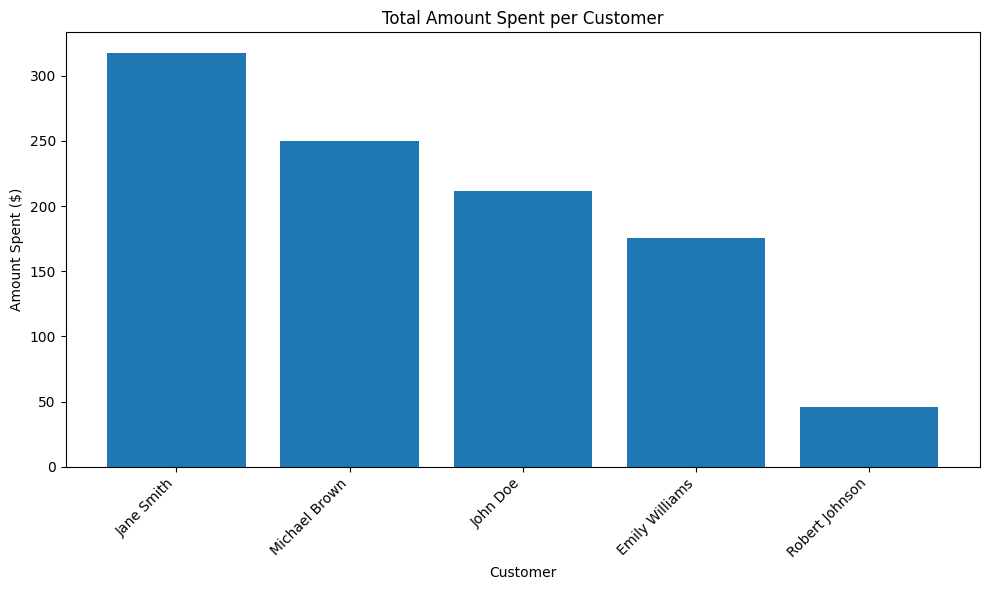

In [6]:
# Query 1: Get all customers
cursor.execute("SELECT * FROM customers")
df_customers = pd.DataFrame(cursor.fetchall(),
                           columns=[desc[0] for desc in cursor.description])
display(Markdown("### All Customers"))
display(df_customers)

# Query 2: Get total orders per customer
cursor.execute('''
SELECT
    c.customer_id,
    c.first_name || ' ' || c.last_name AS customer_name,
    COUNT(o.order_id) AS total_orders,
    SUM(o.total_amount) AS total_spent
FROM
    customers c
LEFT JOIN
    orders o ON c.customer_id = o.customer_id
GROUP BY
    c.customer_id
ORDER BY
    total_spent DESC
''')
df_customer_orders = pd.DataFrame(cursor.fetchall(),
                                 columns=[desc[0] for desc in cursor.description])
display(Markdown("### Customer Order Summary"))
display(df_customer_orders)

# Query 3: Visualize customer spending
plt.figure(figsize=(10, 6))
plt.bar(df_customer_orders['customer_name'], df_customer_orders['total_spent'])
plt.title('Total Amount Spent per Customer')
plt.xlabel('Customer')
plt.ylabel('Amount Spent ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Stage 5: Implement Advanced Queries and Transactions

In [7]:
# Begin a transaction
conn.execute("BEGIN TRANSACTION")

try:
    # Update customer status based on spending
    cursor.execute('''
    UPDATE customers
    SET active = 0
    WHERE customer_id NOT IN (
        SELECT DISTINCT customer_id FROM orders
        WHERE total_amount > 100
    )
    ''')

    # Add a loyalty field to high-value customers
    cursor.execute('''
    ALTER TABLE customers ADD COLUMN loyalty_tier TEXT DEFAULT 'bronze'
    ''')

    # Update loyalty tiers based on spending patterns
    cursor.execute('''
    UPDATE customers
    SET loyalty_tier =
        CASE
            WHEN (SELECT SUM(total_amount) FROM orders WHERE customer_id = customers.customer_id) > 300 THEN 'gold'
            WHEN (SELECT SUM(total_amount) FROM orders WHERE customer_id = customers.customer_id) > 150 THEN 'silver'
            ELSE 'bronze'
        END
    ''')

    # Commit the transaction
    conn.commit()
    print("Transaction completed successfully!")

except sqlite3.Error as e:
    # Rollback in case of error
    conn.rollback()
    print(f"An error occurred: {e}")

# Show updated customer data
cursor.execute("SELECT customer_id, first_name, last_name, active, loyalty_tier FROM customers")
updated_customers = pd.DataFrame(cursor.fetchall(),
                                columns=[desc[0] for desc in cursor.description])
display(Markdown("### Updated Customer Data with Loyalty Tiers"))
display(updated_customers)

Transaction completed successfully!


### Updated Customer Data with Loyalty Tiers

,customer_id,first_name,last_name,active,loyalty_tier
0,1,John,Doe,1,silver
1,2,Jane,Smith,1,gold
2,3,Robert,Johnson,0,bronze
3,4,Emily,Williams,1,silver
4,5,Michael,Brown,1,silver


### Stage 6: Clean Up

In [8]:
# Close connection
conn.close()
print("Connection closed.")

Connection closed.
